In [25]:
#a Tensor library with GPU support
import torch

#Datasets, Transforms and Models specific to Computer Vision
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

#differentiation library that supports all differentiable Tensor operations in torch
from torch.autograd import Variable

#a neural networks library integrated with autograd functionality
import torch.nn as nn

#an optimization package with standard optimization methods such as SGD, RMSProp, LBFGS, Adam etc.
import torch.optim as optim

#scientific computing library for Python
import numpy as np

#plotting and visualization library
import matplotlib.pyplot as plt
#Display on the notebook
%matplotlib inline
plt.ion() #Turn interactive mode on.

from torch.utils.data import Dataset
from torchinfo import summary
import random

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [17]:
trainimgfolder = torchvision.datasets.ImageFolder(root='DVCL/train/',transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))]))

trainloader = torch.utils.data.DataLoader(trainimgfolder, batch_size=16,
                                            shuffle=True, num_workers=2)

testimgfolder = torchvision.datasets.ImageFolder(root='DVCL/test/',transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                            (0.5, 0.5, 0.5))]))

testloader = torch.utils.data.DataLoader(testimgfolder, batch_size=8,
                                            shuffle=True, num_workers=2)



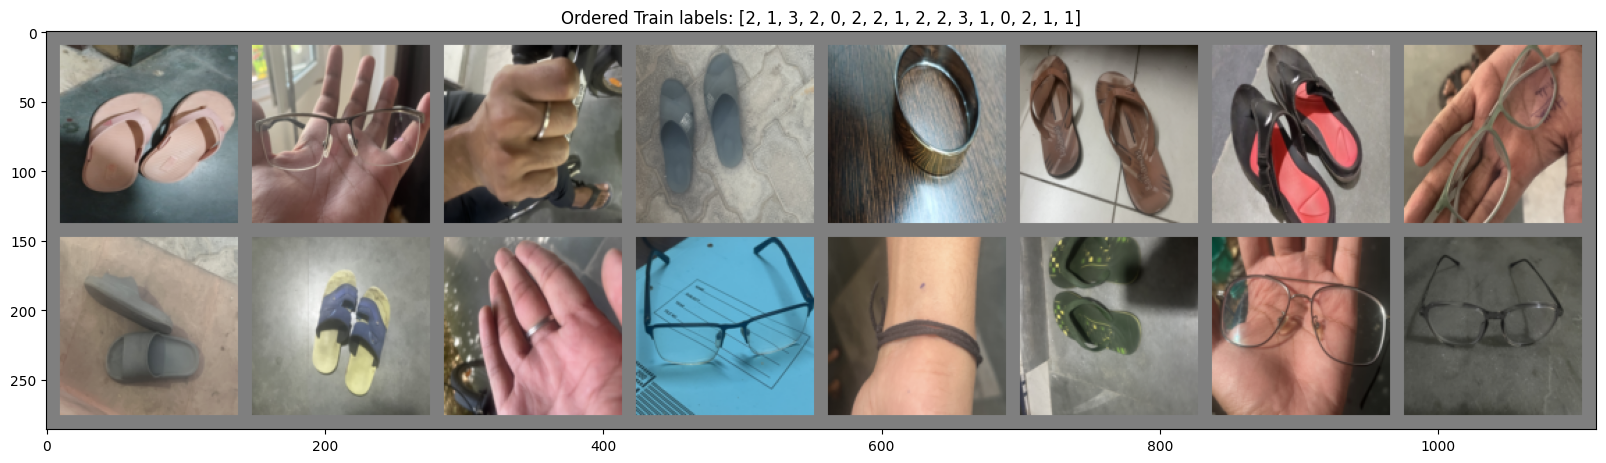

In [29]:
import torchvision
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print images with padding and labels
plt.figure(figsize=(20,20))
imshow(torchvision.utils.make_grid(images, padding=10))
plt.title(f"Ordered Train labels: {[*labels.numpy()]}")
plt.show()


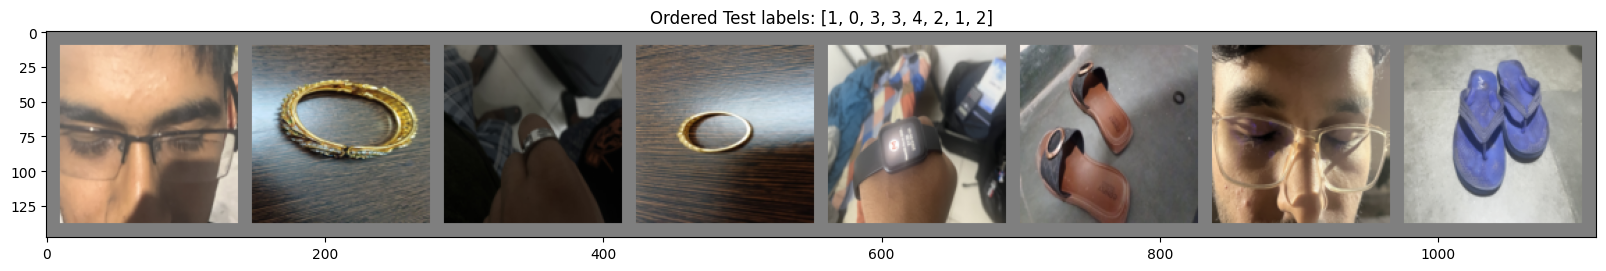

In [30]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images with padding and labels
plt.figure(figsize=(20,20))
imshow(torchvision.utils.make_grid(images, padding=10))
plt.title(f"Ordered Test labels: {[*labels.numpy()]}")
plt.show()


In [26]:
class Model(nn.Module):

    def __init__(self): 
        super(Model, self).__init__()    

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)        
        self.relu2 = nn.ReLU()        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)       
        self.relu3 = nn.ReLU()        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)              # Fully connected layers        
        self.fc1 = nn.Linear(128 * 16 * 16, 128)  # 16x16 is the feature map size after 3 pooling layers        
        self.relu4 = nn.ReLU()    
        self.fc2 = nn.Linear(128, 5)  

    def forward(self, x):        
        x = self.pool1(self.relu1(self.conv1(x)))       
        x = self.pool2(self.relu2(self.conv2(x)))        
        x = self.pool3(self.relu3(self.conv3(x)))       
        x = x.view(x.size(0), -1)  # Flatten the tensor            
        x = self.relu4(self.fc1(x))      
        x = self.fc2(x)        
        return x
        

In [27]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model.cuda()
n_epochs = 25


In [28]:
summary(model, input_size=(1, 3, 128, 128))

/home/aeternum/anaconda3/envs/vcl/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 5]                    --
├─Conv2d: 1-1                            [1, 32, 128, 128]         896
├─ReLU: 1-2                              [1, 32, 128, 128]         --
├─MaxPool2d: 1-3                         [1, 32, 64, 64]           --
├─Conv2d: 1-4                            [1, 64, 64, 64]           18,496
├─ReLU: 1-5                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-6                         [1, 64, 32, 32]           --
├─Conv2d: 1-7                            [1, 128, 32, 32]          73,856
├─ReLU: 1-8                              [1, 128, 32, 32]          --
├─MaxPool2d: 1-9                         [1, 128, 16, 16]          --
├─Linear: 1-10                           [1, 128]                  4,194,432
├─ReLU: 1-11                             [1, 128]                  --
├─Linear: 1-12                           [1, 5]                    64

In [95]:
# Lists to store training loss and accuracy
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

# Training loop
for epoch in range(n_epochs):
    model.train() # Set the model in training mode   
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda().long())

        optimizer.zero_grad() # Zero the gradients        
        outputs = model(inputs) # Forward pass        
        loss = criterion(outputs, labels) # Calculate the loss      
        loss.backward() # Backpropagation        
        optimizer.step() # Update weights        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate accuracy for this epoch    
    epoch_accuracy = correct_predictions / total_samples * 100
    epoch_loss = total_loss / len(trainloader)
    # Print training statistics for this epoch    
    
    # Save training loss and accuracy   
    train_loss_history.append(epoch_loss) 
    train_accuracy_history.append(epoch_accuracy)

    # Testing
    model.eval()
    correct_predictions = 0
    total_samples = 0
    total_test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda().long())
            outputs = model(inputs)
            total_test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    test_accuracy = correct_predictions / total_samples * 100
    test_accuracy_history.append(test_accuracy)

    test_loss = total_test_loss / len(trainloader)
    test_loss_history.append(test_loss)

    print(f"Epoch [{epoch + 1}/{n_epochs}] Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    scheduler.step()

Epoch [1/25] Loss: 1.6170, Test Loss: 1.5967, Train Accuracy: 21.2644, Test Accuracy: 25.2874
Epoch [2/25] Loss: 1.5967, Test Loss: 1.5459, Train Accuracy: 27.5862, Test Accuracy: 39.0805
Epoch [3/25] Loss: 1.5629, Test Loss: 1.4534, Train Accuracy: 32.7586, Test Accuracy: 35.6322
Epoch [4/25] Loss: 1.5613, Test Loss: 1.4748, Train Accuracy: 33.3333, Test Accuracy: 37.9310
Epoch [5/25] Loss: 1.5821, Test Loss: 1.4957, Train Accuracy: 27.0115, Test Accuracy: 34.4828
Epoch [6/25] Loss: 1.5255, Test Loss: 1.5956, Train Accuracy: 32.7586, Test Accuracy: 22.4138
Epoch [7/25] Loss: 1.5153, Test Loss: 1.3828, Train Accuracy: 39.0805, Test Accuracy: 37.3563
Epoch [8/25] Loss: 1.2942, Test Loss: 1.1711, Train Accuracy: 48.2759, Test Accuracy: 60.3448
Epoch [9/25] Loss: 1.1264, Test Loss: 1.0485, Train Accuracy: 58.0460, Test Accuracy: 62.6437
Epoch [10/25] Loss: 1.0133, Test Loss: 0.9304, Train Accuracy: 65.5172, Test Accuracy: 70.1149
Epoch [11/25] Loss: 0.9275, Test Loss: 0.8347, Train Accura

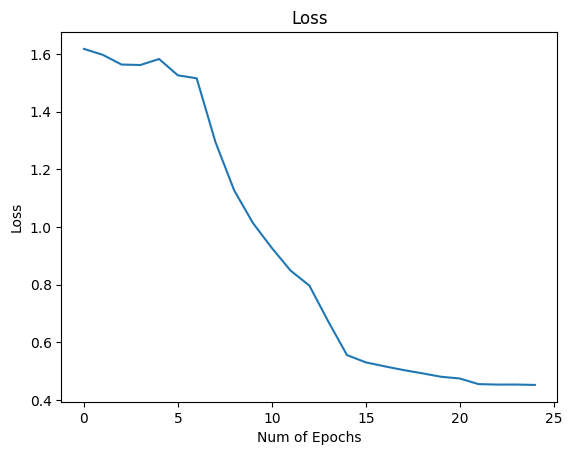

In [115]:
plt.plot(train_loss_history)
plt.title('Loss')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.show()

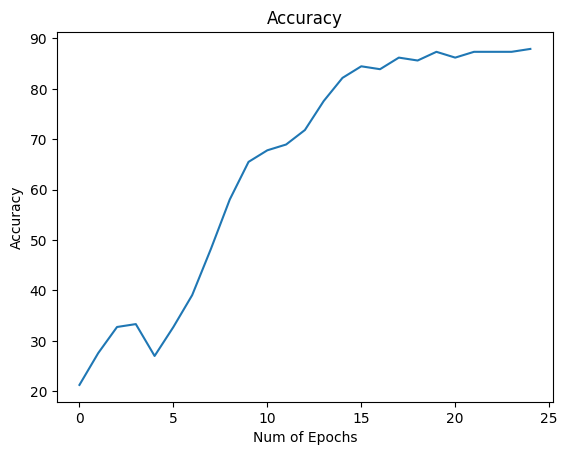

In [116]:
plt.plot(train_accuracy_history)
plt.title('Accuracy')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.show()

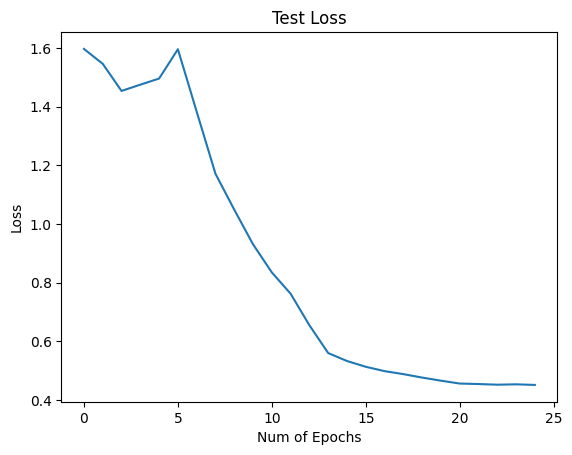

In [117]:
plt.plot(test_loss_history)
plt.title('Test Loss')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.show()

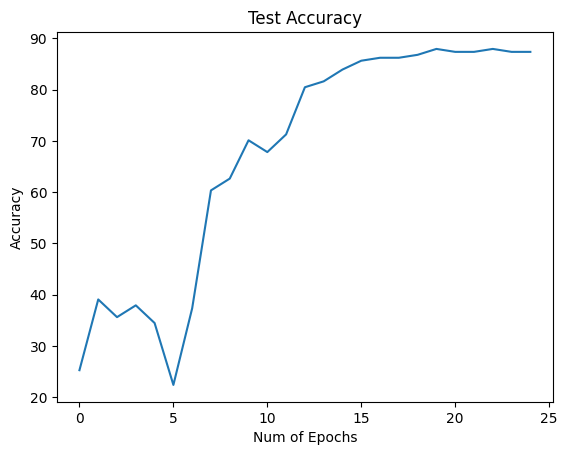

In [118]:
plt.plot(test_accuracy_history)
plt.title('Test Accuracy')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.show()

In [22]:
def create_black_patch(image):

    black_patch = torch.ones(image.size())
    h, w = image.size(1), image.size(2)
    x = random.randint(0, w - 32)
    y = random.randint(0, h - 32)

    black_patch[:,y:y+32,x:x+32] = 0*torch.ones_like(image[:,y:y+32,x:x+32])
    return image*black_patch

In [23]:
testimg_folder = torchvision.datasets.ImageFolder(root='DVCL/test/',transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: create_black_patch(x)),
    transforms.Normalize((0.5, 0.5, 0.5),
                            (0.5, 0.5, 0.5))]))

test_loader = torch.utils.data.DataLoader(testimg_folder, batch_size=8,
                                            shuffle=True, num_workers=2)

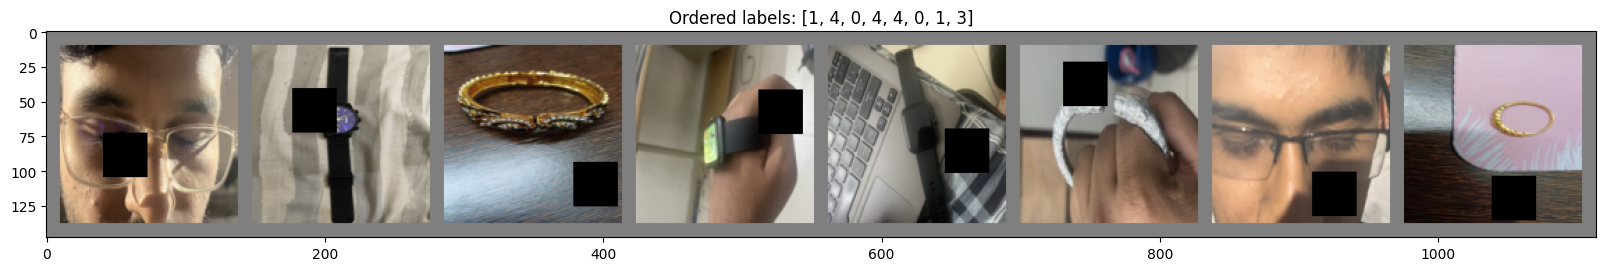

In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images with padding and labels
plt.figure(figsize=(20,20))
imshow(torchvision.utils.make_grid(images, padding=10))
plt.title(f"Ordered labels: {[*labels.numpy()]}")
plt.show()


In [136]:
class Model(nn.Module):

    def __init__(self): 
        super(Model, self).__init__()    

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)        
        self.relu2 = nn.ReLU()        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)       
        self.relu3 = nn.ReLU()        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)              # Fully connected layers        
        self.fc1 = nn.Linear(128 * 16 * 16, 128)  # 16x16 is the feature map size after 3 pooling layers        
        self.relu4 = nn.ReLU()    
        self.fc2 = nn.Linear(128, 5)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, x):        
        x = self.pool1(self.relu1(self.conv1(x)))       
        x = self.pool2(self.relu2(self.conv2(x))) 
        x = self.drop(x)       
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.drop(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor            
        x = self.relu4(self.fc1(x))      
        x = self.fc2(x)        
        return x
        

In [137]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model.cuda()
n_epochs = 25


In [139]:
# Lists to store training loss and accuracy
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

# Training loop
for epoch in range(n_epochs):
    model.train() # Set the model in training mode   
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda().long())

        optimizer.zero_grad() # Zero the gradients        
        outputs = model(inputs) # Forward pass        
        loss = criterion(outputs, labels) # Calculate the loss      
        loss.backward() # Backpropagation        
        optimizer.step() # Update weights        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate accuracy for this epoch    
    epoch_accuracy = correct_predictions / total_samples * 100
    epoch_loss = total_loss / len(trainloader)
    # Print training statistics for this epoch    
    
    # Save training loss and accuracy   
    train_loss_history.append(epoch_loss) 
    train_accuracy_history.append(epoch_accuracy)

    # Testing
    model.eval()
    correct_predictions = 0
    total_samples = 0
    total_test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda().long())
            outputs = model(inputs)
            total_test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    test_accuracy = correct_predictions / total_samples * 100
    test_accuracy_history.append(test_accuracy)

    test_loss = total_test_loss / len(test_loader)
    test_loss_history.append(test_loss)

    print(f"Epoch [{epoch + 1}/{n_epochs}] Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    scheduler.step()

Epoch [1/25] Loss: 1.6147, Test Loss: 1.6276, Train Accuracy: 17.8161, Test Accuracy: 0.0000
Epoch [2/25] Loss: 1.6037, Test Loss: 1.4940, Train Accuracy: 23.5632, Test Accuracy: 100.0000
Epoch [3/25] Loss: 1.5870, Test Loss: 1.5363, Train Accuracy: 27.0115, Test Accuracy: 0.0000
Epoch [4/25] Loss: 1.5808, Test Loss: 1.5333, Train Accuracy: 26.4368, Test Accuracy: 58.8235
Epoch [5/25] Loss: 1.5217, Test Loss: 1.4681, Train Accuracy: 39.0805, Test Accuracy: 41.1765
Epoch [6/25] Loss: 1.5050, Test Loss: 1.4268, Train Accuracy: 36.7816, Test Accuracy: 100.0000
Epoch [7/25] Loss: 1.4816, Test Loss: 1.5739, Train Accuracy: 43.6782, Test Accuracy: 5.8824
Epoch [8/25] Loss: 1.2628, Test Loss: 1.3610, Train Accuracy: 50.0000, Test Accuracy: 23.5294
Epoch [9/25] Loss: 1.1288, Test Loss: 1.0391, Train Accuracy: 55.1724, Test Accuracy: 70.5882
Epoch [10/25] Loss: 1.0353, Test Loss: 0.8523, Train Accuracy: 57.4713, Test Accuracy: 76.4706
Epoch [11/25] Loss: 0.9479, Test Loss: 0.7808, Train Accurac

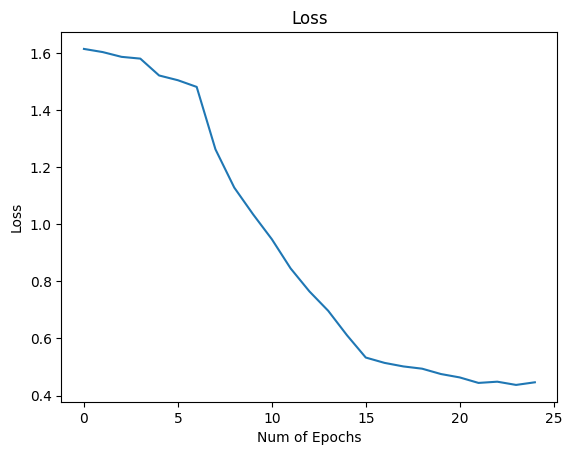

In [140]:
plt.plot(train_loss_history)
plt.title('Loss')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.show()

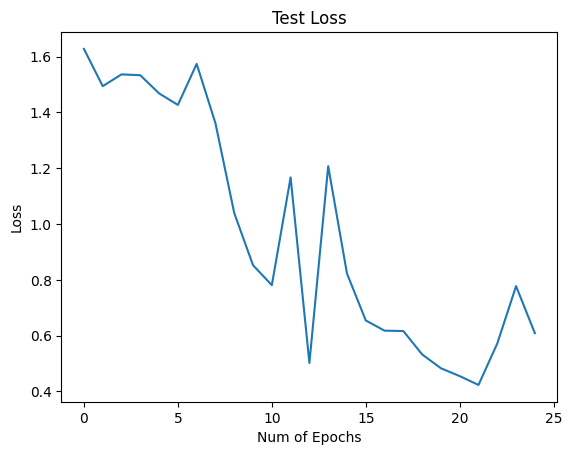

In [141]:
plt.plot(test_loss_history)
plt.title('Test Loss')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.show()

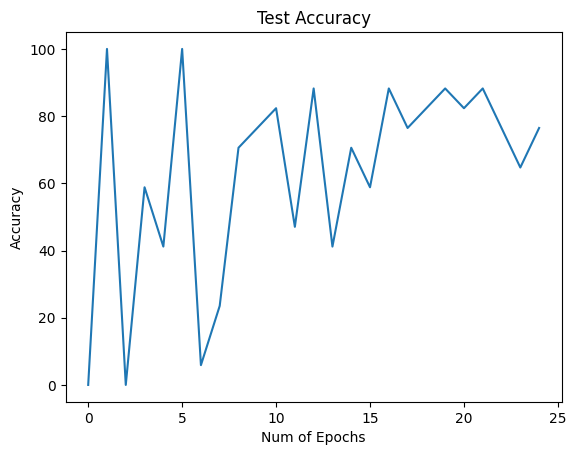

In [142]:
plt.plot(test_accuracy_history)
plt.title('Test Accuracy')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.show()

In [143]:
torch.save(model.state_dict(), 'model.pt')